In [1]:
import json
import pandas as pd
import numpy as np
import re
import string

data = json.load(open('/kaggle/input/json-data/NER_test.json'))
sentence = []
Tag = []
Words = []
count = 0
for i in data:

    for j in data[i]['labels']:
        sentence.append(str(count))
        Tag.append(j)
    for j in data[i]['text'].split():
        # check if there is any special character in the start or end of the word
        if len(j)>2:
            if j[0] in ['.','!','?',',',';',':' ]:
                j = j[1:]
            if j[-1] in ['.','!','?',',',';',':']:
                j = j[:-1]
        Words.append(j)
    count+=1
c = {"Sentence #":sentence,"Word":Words,"Tag":Tag}
print(len(sentence),len(Words),len(Tag))
# save this as csv file
df = pd.DataFrame(c)
df.to_csv('ner_test.csv',index=False)
data = json.load(open('/kaggle/input/json-data/NER_train.json'))
sentence = []
Tag = []
Words = []
count = 0
for i in data:

    for j in data[i]['labels']:
        sentence.append(str(count))
        Tag.append(j)
    for j in data[i]['text'].split():
        # check if there is any special character in the start or end of the word
        if len(j)>2:
            if j[0] in ['.','!','?',',',';',':' ]:
                j = j[1:]
            if j[-1] in ['.','!','?',',',';',':']:
                j = j[:-1]
        Words.append(j)
    count+=1
c = {"Sentence #":sentence,"Word":Words,"Tag":Tag}
print(len(sentence),len(Words),len(Tag))
# save this as csv file
df = pd.DataFrame(c)
df.to_csv('ner_train.csv',index=False)

data = json.load(open('/kaggle/input/json-data/NER_val.json'))
sentence = []
Tag = []
Words = []
count = 0
for i in data:

    for j in data[i]['labels']:
        sentence.append(str(count))
        Tag.append(j)
    for j in data[i]['text'].split():
        # check if there is any special character in the start or end of the word
        if len(j)>2:
            if j[0] in ['.','!','?',',',';',':' ]:
                j = j[1:]
            if j[-1] in ['.','!','?',',',';',':']:
                j = j[:-1]
        Words.append(j)
    count+=1
c = {"Sentence #":sentence,"Word":Words,"Tag":Tag}
print(len(sentence),len(Words),len(Tag))
# save this as csv file
df = pd.DataFrame(c)
df.to_csv('ner_val.csv',index=False)





33753 33753 33753
269722 269722 269722
47517 47517 47517


In [2]:


# data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv", encoding="latin1")

# data = pd.read_csv("/kaggle/input/dsets-t3/train.csv")
# test_data = pd.read_csv("/kaggle/input/dsets-t3/test.csv")
test_data = pd.read_csv("/kaggle/working/ner_test.csv")
data = pd.read_csv("/kaggle/working/ner_train.csv")
val_data = pd.read_csv("/kaggle/working/ner_val.csv")
# print(len(data))
words = []


In [3]:
# print(data.head())
words = []
count = 0
def remove_punct(word):
    pun = list(".,()-:;?!")
    try:
        for i in pun:
            if i in word:
#                 print(i)
                word = word.replace(i,"")
    except:
        word = word
#     print(word)
    return word       
for i in data['Word']:
    words.append(remove_punct(i))

In [4]:
print(len(words),len(data))
data['Word'] = words

269722 269722


In [5]:
data['Tag'].value_counts()



O                 226739
I_PRECEDENT         9648
I_PROVISION         3330
I_CASE_NUMBER       3106
I_STATUTE           2740
B_OTHER_PERSON      2279
I_ORG               2273
I_COURT             2164
B_PROVISION         2042
I_OTHER_PERSON      1772
B_DATE              1590
B_STATUTE           1523
B_ORG               1229
B_GPE               1186
I_DATE              1163
B_PRECEDENT         1123
B_COURT             1103
B_CASE_NUMBER        884
B_WITNESS            760
I_WITNESS            634
B_JUDGE              489
B_PETITIONER         401
I_RESPONDENT         365
I_JUDGE              342
I_PETITIONER         323
B_RESPONDENT         274
I_GPE                240
Name: Tag, dtype: int64

In [6]:
# data.head(1)

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences
print(len(test_sentences),len(sentences))

val_getter = SentenceGetter(val_data)
val_sentences = test_getter.sentences

949 8019


In [8]:
from math import nan
# temp_data = data+test_data
words = list(set(data["Word"].values))
test_words = list(set(test_data['Word'].values))
words = set(words+test_words)
n_words = len(words)

tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)




## Prepare the data
Now we introduce dictionaries of words and tags.

In [9]:
from future.utils import iteritems


word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i:w for w, i in word2idx.items()}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}


In [52]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X_train = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y_train = [to_categorical(i, num_classes=n_tags) for i in y]
X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
print(len(X_test))
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1) 

y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]
print(len(y_test))
y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]
print(len(y_test))


X_val = [[word2idx[w[0]] for w in s] for s in val_sentences]
print(len(X_val))
X_val = pad_sequences(maxlen=maxlen, sequences=X_val, padding="post",value=n_words - 1) 

y_val = [[tag2idx[w[1]] for w in s] for s in val_sentences]
print(len(y_val))
y_val = pad_sequences(maxlen=maxlen, sequences=y_val, padding="post", value=tag2idx["O"])
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
print(len(y_test))
# Split train and test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X_train = data['Word']
# y_train = data['Tag']

# X_test = test_data['Word']
# y_test = test_data['Tag']

print(len(X_test),len(X_train))
import joblib

# Save X_test and y_test
joblib.dump((X_test, y_test), 'test_data.pkl')


949
949
949
949
949
949
949 8019


['test_data.pkl']

## Setup the CRF-BILSTM



In [11]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn_crfsuite


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gqqsw2fj
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gqqsw2fj
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=afe8a8e2e80851dda99e3f66d705fc2d9b86457ab373f3b93a9ebc36c0572399
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijknm0zx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 1.0MB 6.3MB/s eta 0:00:01


In [12]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

In [13]:
print(k.__version__)


2.3.1


## F1 MACRO

In [14]:
from tensorflow.keras.callbacks import Callback
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import f1_score

def F1_Score(y_test,y_pred):
    y_test = np.argmax(y_test, axis=2)
    # Flatten y_pred if necessary
    if y_pred.ndim == 3:
        y_pred = np.argmax(y_pred, axis=2)
    classes = np.unique(y_test)
    precision = []
    recall = []
    f1 = []
    for c in classes:
        tp = np.sum((y_test == c) & (y_pred == c))
        fp = np.sum((y_test != c) & (y_pred == c))
        fn = np.sum((y_test == c) & (y_pred != c))
        
        precision_c = tp / (tp + fp) if tp + fp > 0 else 0
        recall_c = tp / (tp + fn) if tp + fn > 0 else 0
        f1_c = 2 * (precision_c * recall_c) / (precision_c + recall_c) if precision_c + recall_c > 0 else 0
        
        precision.append(precision_c)
        recall.append(recall_c)
        f1.append(f1_c)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    return macro_f1

class F1ScoreCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs={}):
        # Predict on training and validation sets
        y_train_pred = np.argmax(self.model.predict(self.X_train), axis=-1)
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=-1)

        # Calculate F1 scores for training and validation sets
        f1_train = F1_Score(self.y_train, y_train_pred)
        f1_val = F1_Score(self.y_val, y_val_pred)



#         print(f' - F1 Score (train): {f1_train:.4f}')
#         print(f' - F1 Score (val): {f1_val:.4f}')

#         # Log F1 scores to the logs dictionary (for logging with Keras)
        if logs is not None:
            logs['f1_score_train'] = f1_train
            logs['f1_score_val'] = f1_val

        # Print F1 scores
        print(f' - f1_train: {f1_train:.4f} - f1_val: {f1_val:.4f}')
f1_callback = F1ScoreCallback(X_train, np.array(y_train), X_val, np.array(y_val))

## GLOVE

In [15]:
input = Input(shape=(1,))
word_embedding_size = 10

embedding_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_dim = 100
def load_glove_embeddings(embedding_path, embedding_dim, word_index):
    embeddings_index = {}
    with open(embedding_path, encoding='utf-8') as f:
        print(f)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(embedding_path, embedding_dim, word2idx)





<_io.TextIOWrapper name='/kaggle/input/glove6b100dtxt/glove.6B.100d.txt' mode='r' encoding='utf-8'>


In [35]:
from keras.models import Model, Input,Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
# m = 78
m = 76
input = Input(shape=(m,))
word_embedding_size = 100
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=100, input_length=m, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.01)))

model.add(TimeDistributed(Dense(n_tags)))
# model.add(Activation('relu'))
crf = CRF(n_tags)
model.add(crf)
model2 = model

In [36]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 76, 100)           2746600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 76, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 76, 200)           160800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 76, 27)            5427      
_________________________________________________________________
crf_3 (CRF)                  (None, 76, 27)            1539      
Total params: 2,914,366
Trainable params: 2,914,366
Non-trainable params: 0
_________________________________________________________________


In [37]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.02, beta_1=0.5, beta_2=0.5)

# # Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=10, validation_data = (X_val,np.array(y_val)), verbose=1,callbacks=[f1_callback])

import joblib

# Assuming `model` is your Keras model
# Save the model
# joblib.dump(model, "glove_ner_3.pkl")
model.save('t1_model4_glove.h5')

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8019 samples, validate on 949 samples
Epoch 1/10
8019/8019 [==============================] - 14s 2ms/step - loss: 0.2624 - crf_viterbi_accuracy: 0.9398 - accuracy: 0.0037 - val_loss: 0.0755 - val_crf_viterbi_accuracy: 0.9533 - val_accuracy: 0.9525
 - f1_train: 0.5765 - f1_val: 0.4425
Epoch 2/10
8019/8019 [==============================] - 12s 2ms/step - loss: 0.0095 - crf_viterbi_accuracy: 0.9836 - accuracy: 0.0037 - val_loss: 0.0144 - val_crf_viterbi_accuracy: 0.9729 - val_accuracy: 0.9725
 - f1_train: 0.8689 - f1_val: 0.5989
Epoch 3/10
8019/8019 [==============================] - 12s 2ms/step - loss: -0.0254 - crf_viterbi_accuracy: 0.9906 - accuracy: 0.0037 - val_loss: -8.6891e-05 - val_crf_viterbi_accuracy: 0.9725 - val_accuracy: 0.9723
 - f1_train: 0.9082 - f1_val: 0.6483
Epoch 4/10
8019/8019 [==============================] - 12s 2ms/step - loss: -0.0483 - crf_viterbi_accuracy: 0.9936 - accuracy: 0.0037 - val_loss: -0.0140 - val_crf_viterbi_accuracy: 0.9715 - val_accurac

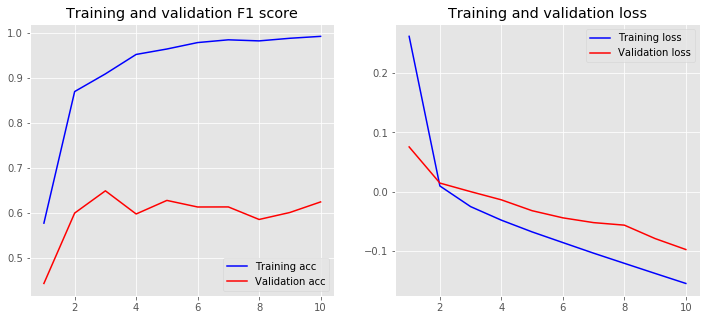

In [38]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['f1_score_train']
    val_accuracy = history.history['f1_score_val']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [51]:
from tensorflow.keras.models import load_model
from keras.models import load_model

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "crf_loss": loss, "crf_viterbi_accuracy":accuracy}

def load_keras_model(path):
    model = load_model(path, custom_objects=create_custom_objects())
    return model

model = load_keras_model('/kaggle/working/t1_model4_glove.h5')
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


949
949/949 [==============================] - 1s 2ms/step
                precision    recall  f1-score   support

 B_CASE_NUMBER       0.60      0.67      0.64       121
       B_COURT       0.91      0.89      0.90       178
        B_DATE       0.79      0.91      0.84       222
         B_GPE       0.65      0.52      0.58       183
       B_JUDGE       0.71      0.62      0.67         8
         B_ORG       0.53      0.42      0.47       159
B_OTHER_PERSON       0.73      0.66      0.69       276
  B_PETITIONER       0.17      0.67      0.27         9
   B_PRECEDENT       0.81      0.63      0.71       177
   B_PROVISION       0.95      0.88      0.92       258
  B_RESPONDENT       0.12      0.40      0.19         5
     B_STATUTE       0.93      0.84      0.88       222
     B_WITNESS       0.72      0.22      0.34        58
 I_CASE_NUMBER       0.71      0.93      0.80       344
       I_COURT       0.88      0.86      0.87       326
        I_DATE       0.84      0.93      0.8

In [ ]:
# ! pip install seqeval


## WORD2VEC


In [42]:
from gensim.models import KeyedVectors
from tqdm import tqdm
input = Input(shape=(76,))
word_embedding_size = 150
embedding_dim = 300
print("here")
word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"  # Replace this with the path to your Word2Vec model

def load_word2vec_embeddings(word2vec_path, embedding_dim, word_index):
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    print("loading done")
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in tqdm(word_index.items()):
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    return embedding_matrix

embedding_matrix = load_word2vec_embeddings(word2vec_path, embedding_dim, word2idx)

here


100%|██████████| 27465/27465 [00:00<00:00, 170363.24it/s]

loading done


In [43]:
# m = 78
m = 76
input = Input(shape=(m,))
word_embedding_size = 100
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=300, input_length=m, weights=[embedding_matrix]))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.01)))

model.add(TimeDistributed(Dense(n_tags)))
# model.add(Activation('relu'))
crf_layer = CRF(n_tags)
model.add(crf_layer)

model2 = model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.005)

# # Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=20, validation_data = (X_val,np.array(y_val)), verbose=1,callbacks=[f1_callback])

import joblib

# Assuming `model` is your Keras model
# Save the model
model.save('t1_model4_word2vec.h5')

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8019 samples, validate on 949 samples
Epoch 1/20
8019/8019 [==============================] - 15s 2ms/step - loss: 0.3802 - crf_viterbi_accuracy: 0.9216 - accuracy: 0.0037 - val_loss: 0.1515 - val_crf_viterbi_accuracy: 0.9575 - val_accuracy: 0.9576
 - f1_train: 0.3783 - f1_val: 0.3426
Epoch 2/20
8019/8019 [==============================] - 13s 2ms/step - loss: 0.0823 - crf_viterbi_accuracy: 0.9738 - accuracy: 0.0037 - val_loss: 0.0822 - val_crf_viterbi_accuracy: 0.9708 - val_accuracy: 0.9704
 - f1_train: 0.6220 - f1_val: 0.4941
Epoch 3/20
8019/8019 [==============================] - 12s 2ms/step - loss: 0.0289 - crf_viterbi_accuracy: 0.9864 - accuracy: 0.0037 - val_loss: 0.0674 - val_crf_viterbi_accuracy: 0.9723 - val_accuracy: 0.9721
 - f1_train: 0.8025 - f1_val: 0.5425
Epoch 4/20
8019/8019 [==============================] - 12s 2ms/step - loss: 0.0058 - crf_viterbi_accuracy: 0.9921 - accuracy: 0.0037 - val_loss: 0.0665 - val_crf_viterbi_accuracy: 0.9724 - val_accuracy: 0.972

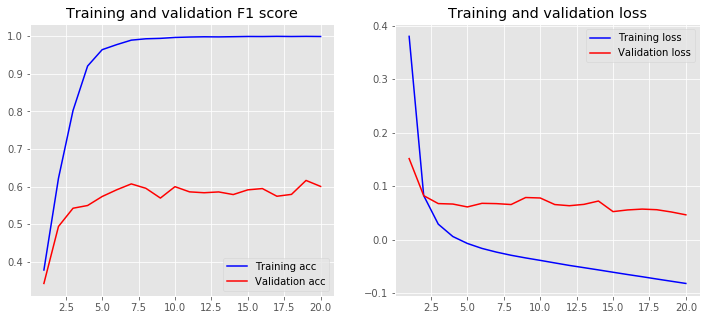

In [46]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['f1_score_train']
    val_accuracy = history.history['f1_score_val']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [47]:
from tensorflow.keras.models import load_model
from keras.models import load_model

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "crf_loss": loss, "crf_viterbi_accuracy":accuracy}

def load_keras_model(path):
    model = load_model(path, custom_objects=create_custom_objects())
    return model

model = load_keras_model('/kaggle/working/t1_model4_word2vec.h5')
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


949
949/949 [==============================] - 2s 2ms/step
                precision    recall  f1-score   support

 B_CASE_NUMBER       0.62      0.57      0.59       121
       B_COURT       0.94      0.87      0.90       178
        B_DATE       0.80      0.70      0.75       222
         B_GPE       0.59      0.49      0.53       183
       B_JUDGE       0.11      0.12      0.12         8
         B_ORG       0.64      0.48      0.55       159
B_OTHER_PERSON       0.77      0.67      0.71       276
  B_PETITIONER       0.38      0.33      0.35         9
   B_PRECEDENT       0.74      0.66      0.70       177
   B_PROVISION       0.91      0.88      0.89       258
  B_RESPONDENT       0.00      0.00      0.00         5
     B_STATUTE       0.86      0.80      0.83       222
     B_WITNESS       0.64      0.31      0.42        58
 I_CASE_NUMBER       0.62      0.78      0.69       344
       I_COURT       0.77      0.88      0.82       326
        I_DATE       0.70      0.92      0.8

## Fast Text

In [53]:
from gensim.models import KeyedVectors
from tqdm import tqdm

word_embedding_size = 150
embedding_dim = 300

In [54]:
import torch
from torchtext.vocab import FastText

# Load FastText embeddings
fasttext = FastText(language='en')

# Get the embedding dimension
embedding_dim = fasttext.dim

# Initialize the embedding matrix
embedding_matrix = torch.zeros((len(word2idx) + 1, embedding_dim))

# Populate the embedding matrix
for word, idx in tqdm(word2idx.items()):
    if word in fasttext.stoi:
        embedding_matrix[idx] = fasttext[word]


100%|█████████▉| 2519013/2519370 [05:45<00:00, 7376.81it/s]

  0%|          | 0/27465 [00:00<?, ?it/s]

100%|██████████| 27465/27465 [00:00<00:00, 162111.91it/s]

100%|█████████▉| 2519013/2519370 [05:59<00:00, 7376.81it/s]

In [56]:
# m = 78
m = 76
input = Input(shape=(m,))
word_embedding_size = 100
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=300, input_length=m, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.01)))

model.add(TimeDistributed(Dense(n_tags)))
# model.add(Activation('relu'))
crf_layer = CRF(n_tags)
model.add(crf_layer)
model2 = model

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.05, beta_1=0.2, beta_2=0.1)

# # Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=20, validation_data = (X_val,np.array(y_val)), verbose=1,callbacks=[f1_callback])

import joblib

# Assuming `model` is your Keras model
# Save the model
model.save('t1_model4_fasttext.h5')

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8019 samples, validate on 949 samples
Epoch 1/20
8019/8019 [==============================] - 15s 2ms/step - loss: 0.3233 - crf_viterbi_accuracy: 0.9103 - accuracy: 0.0037 - val_loss: 0.0382 - val_crf_viterbi_accuracy: 0.9627 - val_accuracy: 0.9625
 - f1_train: 0.6006 - f1_val: 0.4800
Epoch 2/20
8019/8019 [==============================] - 13s 2ms/step - loss: -0.0184 - crf_viterbi_accuracy: 0.9786 - accuracy: 0.0037 - val_loss: 8.8826e-04 - val_crf_viterbi_accuracy: 0.9559 - val_accuracy: 0.9553
 - f1_train: 0.7400 - f1_val: 0.4807
Epoch 3/20
8019/8019 [==============================] - 13s 2ms/step - loss: -0.0715 - crf_viterbi_accuracy: 0.9842 - accuracy: 0.0037 - val_loss: -0.0472 - val_crf_viterbi_accuracy: 0.9620 - val_accuracy: 0.9621
 - f1_train: 0.8231 - f1_val: 0.4911
Epoch 4/20
8019/8019 [==============================] - 13s 2ms/step - loss: -0.1164 - crf_viterbi_accuracy: 0.9845 - accuracy: 0.0037 - val_loss: -0.0806 - val_crf_viterbi_accuracy: 0.9647 - val_accura

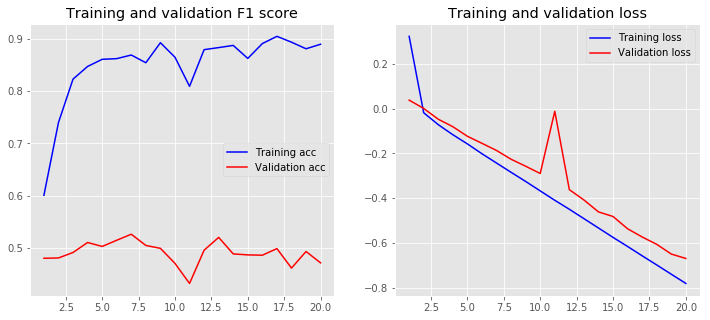

In [57]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['f1_score_train']
    val_accuracy = history.history['f1_score_val']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [58]:
from tensorflow.keras.models import load_model
from keras.models import load_model

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "crf_loss": loss, "crf_viterbi_accuracy":accuracy}

def load_keras_model(path):
    model = load_model(path, custom_objects=create_custom_objects())
    return model

model = load_keras_model('/kaggle/working/t1_model4_fasttext.h5')
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


949
949/949 [==============================] - 2s 2ms/step
                precision    recall  f1-score   support

 B_CASE_NUMBER       0.50      0.42      0.46       121
       B_COURT       0.82      0.84      0.83       178
        B_DATE       0.58      0.89      0.70       222
         B_GPE       0.62      0.30      0.40       183
       B_JUDGE       0.11      0.25      0.15         8
         B_ORG       0.51      0.39      0.44       159
B_OTHER_PERSON       0.30      0.64      0.41       276
  B_PETITIONER       0.12      0.22      0.15         9
   B_PRECEDENT       0.55      0.43      0.48       177
   B_PROVISION       0.90      0.85      0.87       258
  B_RESPONDENT       0.00      0.00      0.00         5
     B_STATUTE       0.79      0.78      0.79       222
     B_WITNESS       0.19      0.21      0.20        58
 I_CASE_NUMBER       0.53      0.64      0.58       344
       I_COURT       0.77      0.80      0.78       326
        I_DATE       0.45      0.87      0.6